In [1]:
from google.colab import files
uploaded = files.upload()

Saving df_train.csv to df_train.csv
Saving df_forecast.csv to df_forecast.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
# 读取数据
df_train = pd.read_csv(
    "df_train.csv",
    index_col=0,
    parse_dates=True
)

df_train.head()


,WaterLevel(m),Flow(L/s),Velocity(m/s),WaterTemperature(_),Precipiation(mm),AirTemperature(_),RelativeHumidity(%),VaporPressure(kPa),WindSpeed(m/s),WindDirection
Datetime,,,,,,,,,,
2022-10-01 00:00:00,1.364,176.934,0.352,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:01:00,1.364,186.988,0.372,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:02:00,1.364,181.961,0.362,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:03:00,1.364,176.934,0.352,22.882,0.0,21.4,83.0,1007.0,0.0,0.0
2022-10-01 00:04:00,1.364,186.988,0.372,22.882,0.0,21.4,83.0,1007.0,0.0,0.0


In [4]:
# 时间范围检查
print(df_train.index.min(), df_train.index.max())

# 缺失值检查
df_train.isna().sum()


2022-10-01 00:00:00 2022-11-11 23:59:00


,0
WaterLevel(m),0
Flow(L/s),0
Velocity(m/s),0
WaterTemperature(_),0
Precipiation(mm),0
AirTemperature(_),0
RelativeHumidity(%),0
VaporPressure(kPa),0
WindSpeed(m/s),0
WindDirection,0


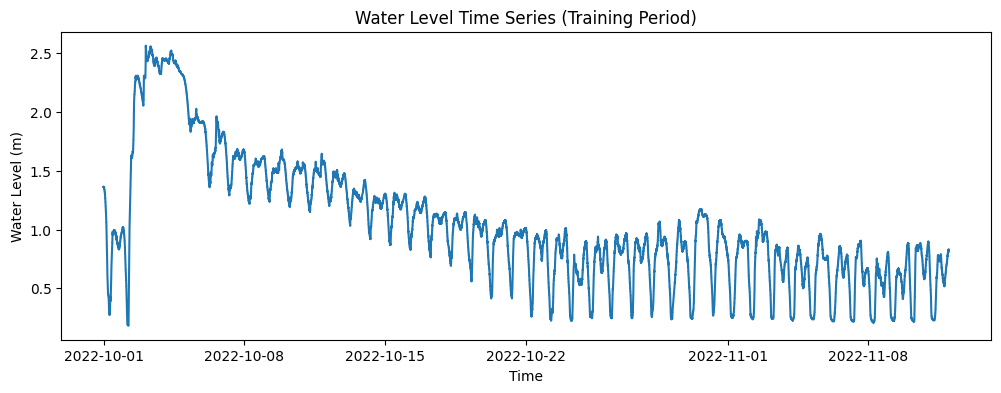

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df_train.index, df_train["WaterLevel(m)"])
plt.title("Water Level Time Series (Training Period)")
plt.xlabel("Time")
plt.ylabel("Water Level (m)")
plt.show()


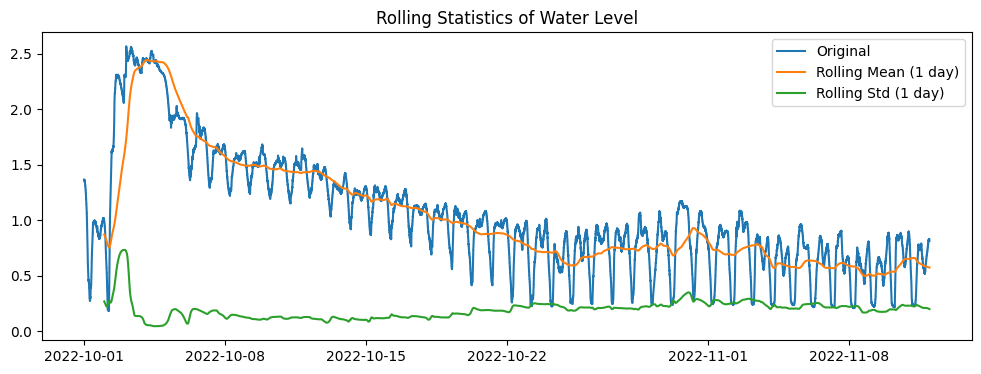

In [6]:
rolling_mean = df_train["WaterLevel(m)"].rolling(1440).mean()
rolling_std = df_train["WaterLevel(m)"].rolling(1440).std()

plt.figure(figsize=(12,4))
plt.plot(df_train["WaterLevel(m)"], label="Original")
plt.plot(rolling_mean, label="Rolling Mean (1 day)")
plt.plot(rolling_std, label="Rolling Std (1 day)")
plt.legend()
plt.title("Rolling Statistics of Water Level")
plt.show()


In [7]:
adf_result = adfuller(df_train["WaterLevel(m)"])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -5.04287541635036
p-value: 1.82418972240589e-05


<Figure size 1200x400 with 0 Axes>

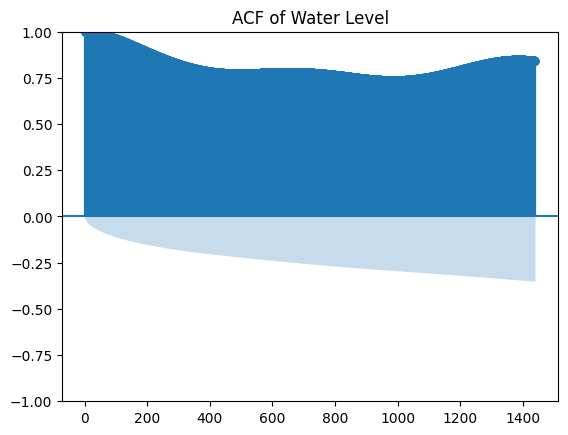

<Figure size 1200x400 with 0 Axes>

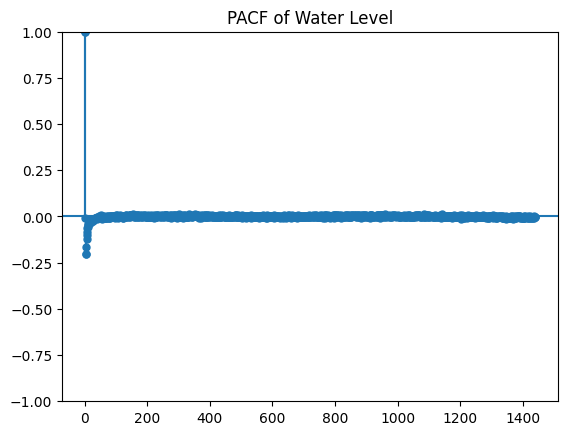

In [8]:
plt.figure(figsize=(12,4))
plot_acf(df_train["WaterLevel(m)"], lags=1440)
plt.title("ACF of Water Level")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df_train["WaterLevel(m)"], lags=1440)
plt.title("PACF of Water Level")
plt.show()


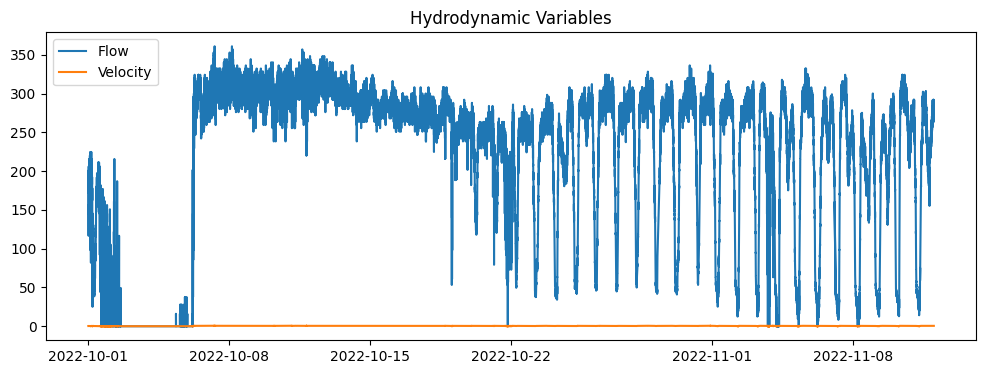

In [9]:
plt.figure(figsize=(12,4))
plt.plot(df_train["Flow(L/s)"], label="Flow")
plt.plot(df_train["Velocity(m/s)"], label="Velocity")
plt.legend()
plt.title("Hydrodynamic Variables")
plt.show()


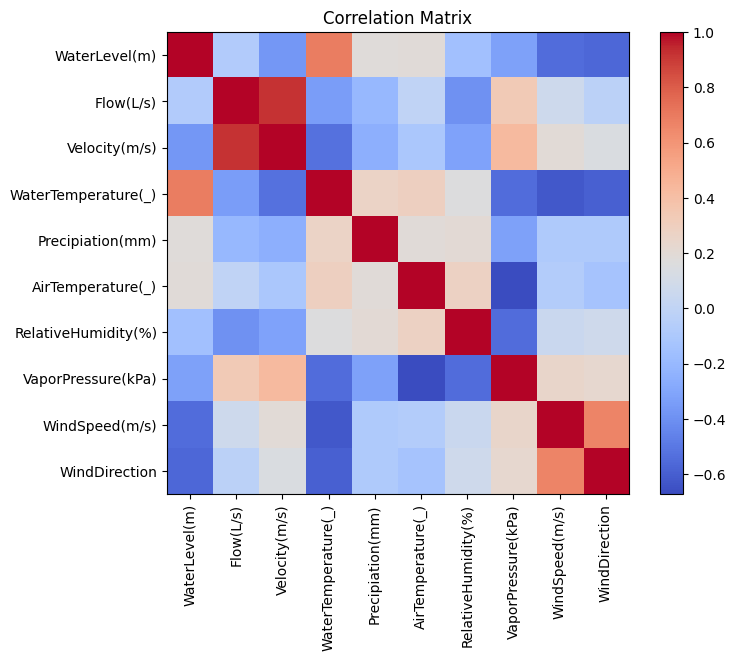

In [10]:
corr = df_train.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Matrix")
plt.show()


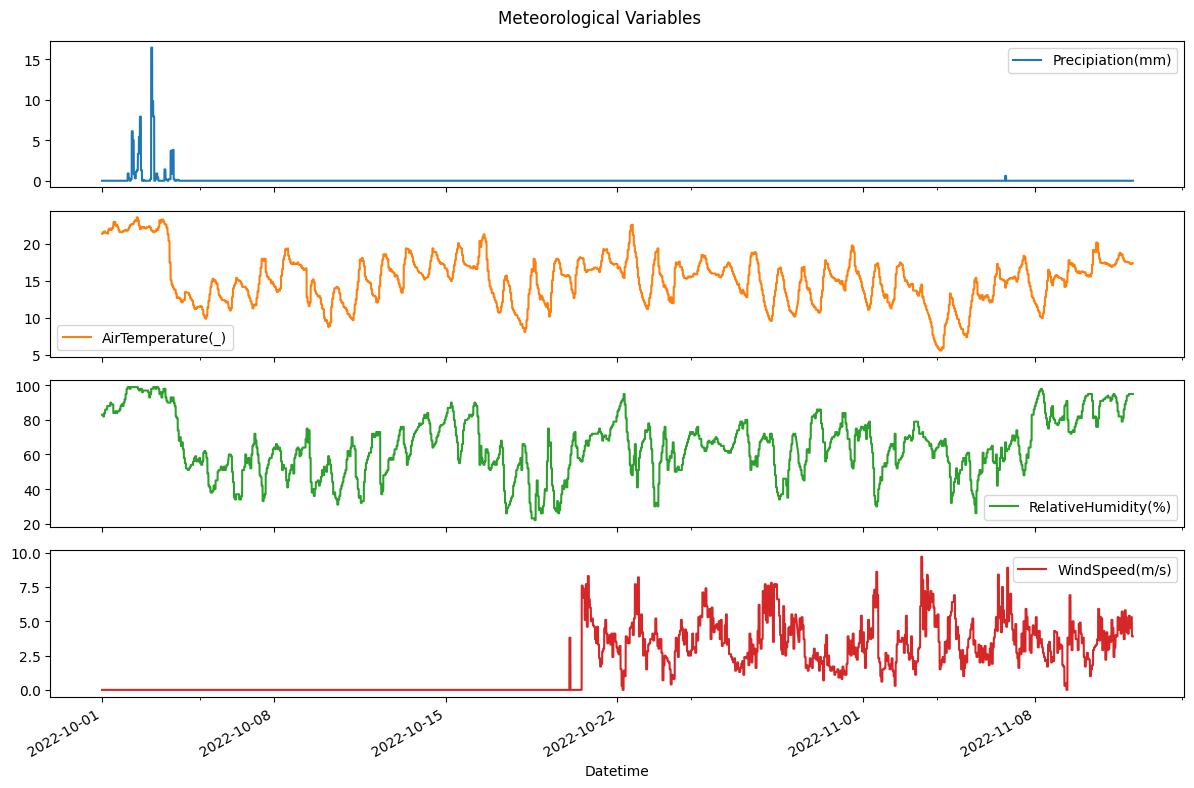

In [11]:
met_cols = [
    "Precipiation(mm)",
    "AirTemperature(_)",
    "RelativeHumidity(%)",
    "WindSpeed(m/s)"
]

df_train[met_cols].plot(
    subplots=True,
    figsize=(12,8),
    title="Meteorological Variables"
)
plt.tight_layout()
plt.show()


In [12]:
# 滞后相关（以 Flow 为例）
df_lag = df_train[["WaterLevel(m)", "Flow(L/s)"]].copy()
df_lag["Flow_lag_60"] = df_lag["Flow(L/s)"].shift(60)

df_lag.dropna(inplace=True)

df_lag.corr()


,WaterLevel(m),Flow(L/s),Flow_lag_60
WaterLevel(m),1.000000,-0.074017,-0.097273
Flow(L/s),-0.074017,1.000000,0.939419
Flow_lag_60,-0.097273,0.939419,1.000000


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error

# ====== 读数据 ======
df_train = pd.read_csv("df_train.csv", index_col=0, parse_dates=True)
df_forecast = pd.read_csv("df_forecast.csv", index_col=0, parse_dates=True)

# 排序 & 频率（如有必要）
df_train = df_train.sort_index()
df_forecast = df_forecast.sort_index()

TARGET = "WaterLevel(m)"

# 外生变量（按你数据列名来）
EXOG_COLS = [
    "Flow(L/s)",
    "Velocity(m/s)",
    "Precipiation(mm)",
    "AirTemperature(_)",
    "RelativeHumidity(%)",
    "VaporPressure(kPa)",
    "WindSpeed(m/s)",
    "WindDirection",
    "WaterTemperature(_)"
]

# 只保留存在的列（防止你某些列没有）
EXOG_COLS = [c for c in EXOG_COLS if c in df_train.columns]

print("训练集范围:", df_train.index.min(), "->", df_train.index.max())
print("预测集范围:", df_forecast.index.min(), "->", df_forecast.index.max())
print("使用外生变量数:", len(EXOG_COLS), EXOG_COLS)
print("训练集缺失值总数:", df_train.isna().sum().sum())
print("预测集缺失值总数:", df_forecast.isna().sum().sum())


训练集范围: 2022-10-01 00:00:00 -> 2022-11-11 23:59:00
预测集范围: 2022-11-11 00:00:00 -> 2022-12-01 23:59:00
使用外生变量数: 9 ['Flow(L/s)', 'Velocity(m/s)', 'Precipiation(mm)', 'AirTemperature(_)', 'RelativeHumidity(%)', 'VaporPressure(kPa)', 'WindSpeed(m/s)', 'WindDirection', 'WaterTemperature(_)']
训练集缺失值总数: 0
预测集缺失值总数: 0


In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def safe_metrics(y_true, y_pred, name=""):
    out = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred)
    }
    print(f"[{name}] MAE={out['MAE']:.6f}, RMSE={out['RMSE']:.6f}")
    return out

# 建议：用训练集最后 20% 做验证（你也可以改成最后 7 天）
split_idx = int(len(df_train) * 0.8)
df_tr = df_train.iloc[:split_idx].copy()
df_va = df_train.iloc[split_idx:].copy()

print("Train子集:", df_tr.index.min(), "->", df_tr.index.max(), "len=", len(df_tr))
print("Valid子集:", df_va.index.min(), "->", df_va.index.max(), "len=", len(df_va))


Train子集: 2022-10-01 00:00:00 -> 2022-11-03 17:25:00 len= 47355
Valid子集: 2022-11-03 17:26:00 -> 2022-11-11 23:59:00 len= 11839


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:          WaterLevel(m)   No. Observations:                47355
Model:               SARIMAX(1, 0, 1)   Log Likelihood              126133.232
Date:                Fri, 16 Jan 2026   AIC                        -252242.463
Time:                        03:50:34   BIC                        -252137.278
Sample:                             0   HQIC                       -252209.431
                              - 47355                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Flow(L/s)               0.0085   3.29e-05    259.738      0.000       0.008       0.009
Velocity(m/s)          -4.1710      0.016   -253.564      0.000      -4.203      -4.139
Precipiation(mm)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMAX验证预测耗时(秒): 0.3429040949999944
[SARIMAX Valid] MAE=0.253235, RMSE=0.333251


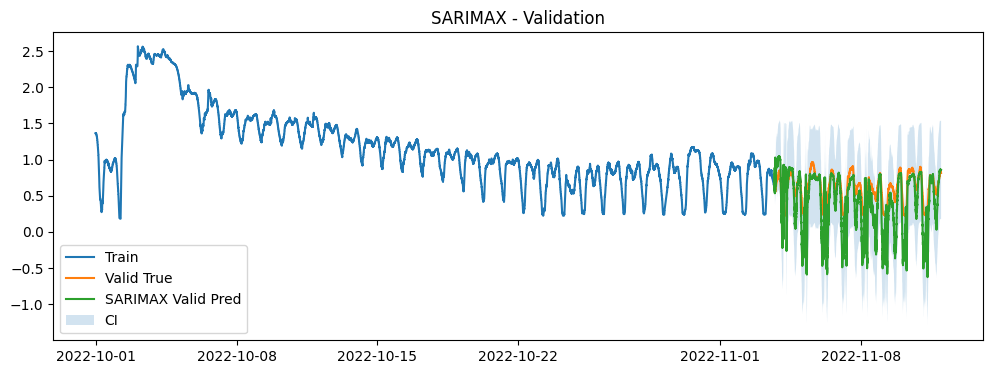

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/stat

SARIMAX全量训练耗时(秒): 154.29410454000026
SARIMAX未来预测耗时(秒): 0.7545843480002077


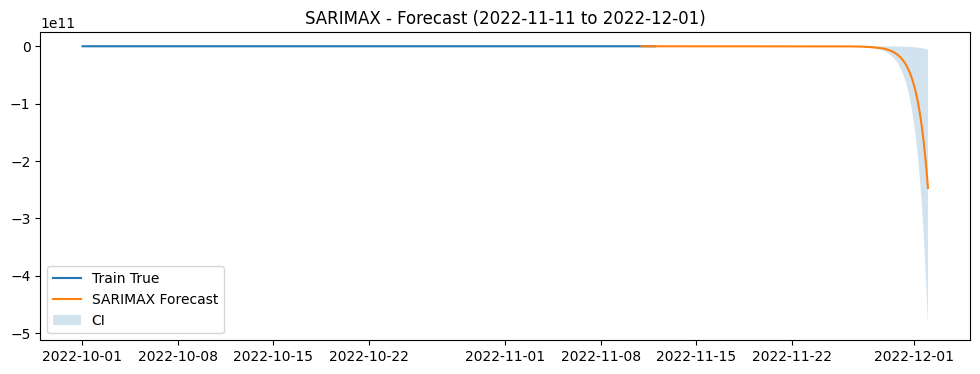

[SARIMAX Forecast] MAE=9417836461.820906, RMSE=34104221043.267723


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fit_sarimax(train_df, exog_cols, order=(1,0,1), seasonal_order=(0,0,0,0)):
    y = train_df[TARGET]
    X = train_df[exog_cols] if exog_cols else None

    model = SARIMAX(
        y,
        exog=X,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    t0 = time.perf_counter()
    res = model.fit(disp=False)
    train_time = time.perf_counter() - t0
    return res, train_time

def predict_sarimax(res, exog_future):
    t0 = time.perf_counter()
    fc = res.get_forecast(steps=len(exog_future), exog=exog_future)
    pred = fc.predicted_mean
    ci = fc.conf_int()
    pred_time = time.perf_counter() - t0
    return pred, ci, pred_time

# ====== 你可以从最稳的起点开始：order=(1,0,1) ======
ORDER = (1, 0, 1)
SEASONAL = (0, 0, 0, 0)  # 如果你想加日周期，可后续再扩展

sarimax_res, sarimax_train_time = fit_sarimax(df_tr, EXOG_COLS, ORDER, SEASONAL)
print(sarimax_res.summary())
print("SARIMAX训练耗时(秒):", sarimax_train_time)

# ====== 验证集预测 ======
X_va = df_va[EXOG_COLS] if EXOG_COLS else None
y_va_true = df_va[TARGET]

sarimax_va_pred, sarimax_va_ci, sarimax_va_pred_time = predict_sarimax(sarimax_res, X_va)
print("SARIMAX验证预测耗时(秒):", sarimax_va_pred_time)
safe_metrics(y_va_true, sarimax_va_pred, name="SARIMAX Valid")

plt.figure(figsize=(12,4))
plt.plot(df_tr.index, df_tr[TARGET], label="Train")
plt.plot(df_va.index, y_va_true, label="Valid True")
plt.plot(df_va.index, sarimax_va_pred, label="SARIMAX Valid Pred")
plt.fill_between(df_va.index, sarimax_va_ci.iloc[:,0], sarimax_va_ci.iloc[:,1], alpha=0.2, label="CI")
plt.legend()
plt.title("SARIMAX - Validation")
plt.show()

# ====== 用全训练期重训，再预测未来（2022-11-11~2022-12-01） ======
sarimax_res_full, sarimax_train_time_full = fit_sarimax(df_train, EXOG_COLS, ORDER, SEASONAL)
X_future = df_forecast[EXOG_COLS] if EXOG_COLS else None

sarimax_future_pred, sarimax_future_ci, sarimax_future_pred_time = predict_sarimax(sarimax_res_full, X_future)

print("SARIMAX全量训练耗时(秒):", sarimax_train_time_full)
print("SARIMAX未来预测耗时(秒):", sarimax_future_pred_time)

plt.figure(figsize=(12,4))
plt.plot(df_train.index, df_train[TARGET], label="Train True")
plt.plot(df_forecast.index, sarimax_future_pred, label="SARIMAX Forecast")
plt.fill_between(df_forecast.index, sarimax_future_ci.iloc[:,0], sarimax_future_ci.iloc[:,1], alpha=0.2, label="CI")
plt.legend()
plt.title("SARIMAX - Forecast (2022-11-11 to 2022-12-01)")
plt.show()

# 如果 df_forecast 里也有真实 WaterLevel(m)，就顺便评估
if TARGET in df_forecast.columns:
    safe_metrics(df_forecast[TARGET], sarimax_future_pred, name="SARIMAX Forecast")


LGB训练样本: (45915, 31) 验证样本: (11839, 31)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4722
[LightGBM] [Info] Number of data points in the train set: 45915, number of used features: 31
[LightGBM] [Info] Start training from score 1.154998
LightGBM训练耗时(秒): 18.32396709600016
LightGBM验证预测耗时(秒): 3.4076213110001845
[LightGBM Valid] MAE=0.003533, RMSE=0.004826


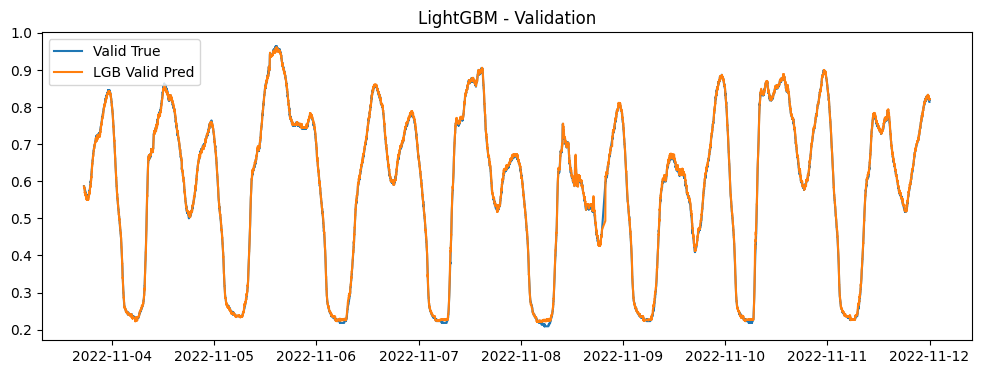

In [18]:
# 如果你本地没有 lightgbm：
!pip install lightgbm

from lightgbm import LGBMRegressor

def add_time_features(df):
    out = df.copy()
    idx = out.index
    out["hour"] = idx.hour
    out["dayofweek"] = idx.dayofweek
    out["day"] = idx.day
    out["month"] = idx.month
    return out

def make_lgb_features(df, exog_cols, lags=(1,2,5,10,30,60), rolls=(30,60,180,1440)):
    """
    df: 必须包含 TARGET 和 exog_cols
    lags: 目标滞后步
    rolls: rolling窗口(以行数为单位；若你的频率是1分钟，1440=1天)
    """
    data = add_time_features(df)

    # target lag features
    for L in lags:
        data[f"{TARGET}_lag_{L}"] = data[TARGET].shift(L)

    # rolling features on target
    for w in rolls:
        data[f"{TARGET}_roll_mean_{w}"] = data[TARGET].shift(1).rolling(w).mean()
        data[f"{TARGET}_roll_std_{w}"]  = data[TARGET].shift(1).rolling(w).std()

    # 可选：外生变量滞后（通常对降雨等有帮助）
    # 这里给个保守做法：只给降雨加滞后
    if "Precipiation(mm)" in exog_cols:
        for L in (30, 60, 180, 1440):
            data[f"Precip_lag_{L}"] = data["Precipiation(mm)"].shift(L)

    # 训练用特征列
    feature_cols = []
    feature_cols += exog_cols
    feature_cols += ["hour", "dayofweek", "day", "month"]
    feature_cols += [c for c in data.columns if c.startswith(f"{TARGET}_lag_")]
    feature_cols += [c for c in data.columns if c.startswith(f"{TARGET}_roll_")]
    feature_cols += [c for c in data.columns if c.startswith("Precip_lag_")]

    # 丢掉因 shift/rolling 产生的 NA
    data = data.dropna()

    X = data[feature_cols]
    y = data[TARGET]
    return X, y, feature_cols

# ====== 训练集上构造监督学习数据（用 df_tr / df_va 做验证） ======
X_tr, y_tr, feat_cols = make_lgb_features(df_tr, EXOG_COLS)
X_va, y_va, _ = make_lgb_features(pd.concat([df_tr.tail(2000), df_va]), EXOG_COLS)  # 拼一点历史保证lag可用

# 注意：上面 X_va/y_va 是对拼接后dropna的结果，包含了部分 df_tr tail 的点
# 我们只取落在验证区间内的样本来评估
va_mask = (X_va.index >= df_va.index.min()) & (X_va.index <= df_va.index.max())
X_va2, y_va2 = X_va.loc[va_mask], y_va.loc[va_mask]

print("LGB训练样本:", X_tr.shape, "验证样本:", X_va2.shape)

lgb = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

t0 = time.perf_counter()
lgb.fit(
    X_tr, y_tr,
    eval_set=[(X_va2, y_va2)],
    eval_metric="rmse",
)
lgb_train_time = time.perf_counter() - t0
print("LightGBM训练耗时(秒):", lgb_train_time)

# ====== 验证集预测评估 ======
t0 = time.perf_counter()
va_pred = lgb.predict(X_va2)
lgb_va_pred_time = time.perf_counter() - t0
print("LightGBM验证预测耗时(秒):", lgb_va_pred_time)
safe_metrics(y_va2, va_pred, name="LightGBM Valid")

plt.figure(figsize=(12,4))
plt.plot(y_va2.index, y_va2.values, label="Valid True")
plt.plot(y_va2.index, va_pred, label="LGB Valid Pred")
plt.legend()
plt.title("LightGBM - Validation")
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4816
[LightGBM] [Info] Number of data points in the train set: 57754, number of used features: 31
[LightGBM] [Info] Start training from score 1.038232
LightGBM全量训练耗时(秒): 22.400288842999544
LightGBM未来递推预测耗时(秒): 311.6652493070005


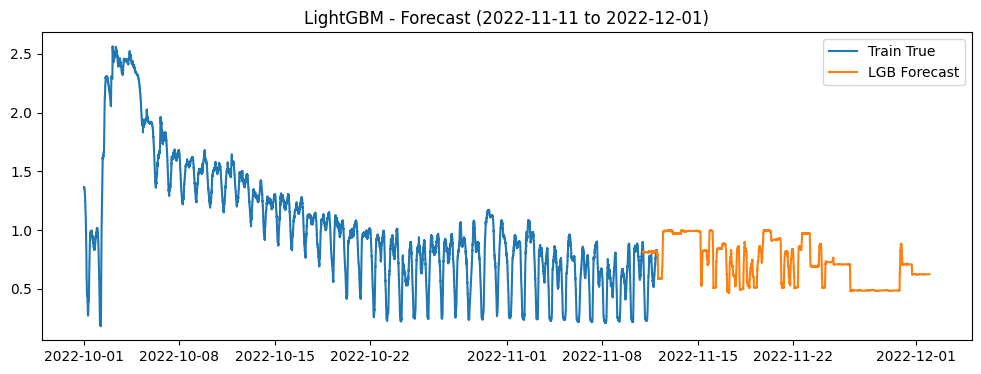

[LightGBM Forecast] MAE=0.282511, RMSE=0.432671


In [22]:
def lgb_recursive_forecast(
    model,
    df_hist,
    df_future,
    exog_cols,
    feat_cols,
    lags=(1, 2, 5, 10, 30, 60),
    rolls=()   # 预测阶段不再用 rolling
):
    """
    修复版 LightGBM 递推预测函数（不报 KeyError，不会卡死）
    """

    import pandas as pd
    import numpy as np

    TARGET = "WaterLevel(m)"

    history = df_hist[[TARGET]].copy()
    preds = []

    for t in df_future.index:
        row = {}

        # 1️⃣ 当前时刻外生变量
        for c in exog_cols:
            row[c] = df_future.loc[t, c]

        # 2️⃣ 时间特征
        row["hour"] = t.hour
        row["dayofweek"] = t.dayofweek
        row["day"] = t.day
        row["month"] = t.month

        # 3️⃣ 目标变量 lag
        for L in lags:
            row[f"{TARGET}_lag_{L}"] = history[TARGET].iloc[-L]

        # 4️⃣ 所有“预测阶段不再计算的特征”统一补 0
        for c in feat_cols:
            if c not in row:
                row[c] = 0.0

        # 5️⃣ 构造模型输入（列顺序严格一致）
        X_t = pd.DataFrame([row])[feat_cols]

        # 6️⃣ 预测
        y_hat = model.predict(X_t)[0]
        preds.append(y_hat)

        # 7️⃣ 更新历史
        history.loc[t, TARGET] = y_hat

    return pd.Series(preds, index=df_future.index, name="LGB_forecast")




# ====== 用“全训练期”重训 LGB（更符合题目最终提交） ======
X_full, y_full, feat_cols_full = make_lgb_features(df_train, EXOG_COLS)

lgb_full = LGBMRegressor(
    n_estimators=2500,
    learning_rate=0.03,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

t0 = time.perf_counter()
lgb_full.fit(X_full, y_full)
lgb_full_train_time = time.perf_counter() - t0
print("LightGBM全量训练耗时(秒):", lgb_full_train_time)

# 预测阶段，确保未来液位不参与输入
df_future_for_pred = df_forecast.copy()
df_future_for_pred["WaterLevel(m)"] = np.nan

t0 = time.perf_counter()
lgb_future_pred = lgb_recursive_forecast(
    model=lgb_full,
    df_hist=df_train[[TARGET] + EXOG_COLS],
    df_future=df_future_for_pred,
    exog_cols=EXOG_COLS,
    feat_cols=feat_cols_full
)
lgb_future_pred_time = time.perf_counter() - t0

print("LightGBM未来递推预测耗时(秒):", lgb_future_pred_time)

plt.figure(figsize=(12,4))
plt.plot(df_train.index, df_train[TARGET], label="Train True")
plt.plot(df_forecast.index, lgb_future_pred, label="LGB Forecast")
plt.legend()
plt.title("LightGBM - Forecast (2022-11-11 to 2022-12-01)")
plt.show()

# 如 df_forecast 有真实液位，则评估
if TARGET in df_forecast.columns:
    safe_metrics(df_forecast[TARGET], lgb_future_pred, name="LightGBM Forecast")


In [23]:
results = []

# SARIMAX（验证集）
results.append({
    "Model": "SARIMAX",
    "TrainTime(s)": sarimax_train_time,
    "PredTime_Valid(s)": sarimax_va_pred_time,
    "MAE_Valid": mean_absolute_error(y_va_true, sarimax_va_pred),
    "RMSE_Valid": rmse(y_va_true, sarimax_va_pred)
})

# LightGBM（验证集）
results.append({
    "Model": "LightGBM",
    "TrainTime(s)": lgb_train_time,
    "PredTime_Valid(s)": lgb_va_pred_time,
    "MAE_Valid": mean_absolute_error(y_va2, va_pred),
    "RMSE_Valid": rmse(y_va2, va_pred)
})

df_results = pd.DataFrame(results).sort_values("RMSE_Valid")
df_results


,Model,TrainTime(s),PredTime_Valid(s),MAE_Valid,RMSE_Valid
1,LightGBM,18.323967,3.407621,0.003533,0.004826
0,SARIMAX,94.818046,0.342904,0.253235,0.333251
